# Assignment 4


OSU ECE 5460, AU23

In this assignment we will explore linear classfiers using CIFAR-10 dataset.


> Before you start: make a copy of this file and saved to your account by `File - Save a copy in Drive`




## 1.1 Loading the CIFAR-10 dataset
and setting the environment
Colab has pytorch preinstalled. You can load the torch package by `import torch`.

In [3]:
import torch
print(torch.__version__)
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA/MPS is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on CUDA GPU...")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on Apple MPS (Metal)...")
else:
    device = torch.device("cpu")
    print("Training on CPU...")

import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

print("\nLoading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

2.9.1
Training on Apple MPS (Metal)...

Loading CIFAR-10 dataset...


Look at some of the training images

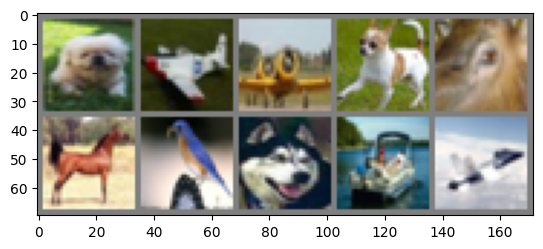

dog   plane plane dog   deer  horse bird  dog   ship  plane


In [4]:
import matplotlib.pyplot as plt


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images,nrow=5))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


Build the model

In [5]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=32*32*3, output_dim=10):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x=torch.flatten(x, 1)
    x = self.linear(x)
    return x

# Initialize model, loss function, and optimizer
model = LinearClassifier()
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#you can play around with the optimization parameters to get better training performance

Train the model

In [ ]:
n_epochs = 25 # you may increase this number to train a final model
print(f"\nTraining for {n_epochs} epochs...")

# Lists to store metrics for visualization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, n_epochs+1):

    ###################
    # train the model #
    ###################
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for data, target in trainloader:
        # move tensors to device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # calculate training accuracy
        _, pred = torch.max(output, 1)
        train_total += target.size(0)
        train_correct += (pred == target).sum().item()

    # calculate average training loss and accuracy
    train_loss = train_loss/len(trainloader.dataset)
    train_acc = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    ###################
    # validate the model #
    ###################
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            # move tensors to device
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # calculate validation accuracy
            _, pred = torch.max(output, 1)
            val_total += target.size(0)
            val_correct += (pred == target).sum().item()
    
    # calculate average validation loss and accuracy
    val_loss = val_loss/len(testloader.dataset)
    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # print training/validation statistics every 5 epochs
    if epoch % 5 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}% \tVal Loss: {:.6f} \tVal Acc: {:.2f}%'.format(
            epoch, train_loss, train_acc, val_loss, val_acc))

print("\nTraining completed!")


Training for 25 epochs...
Epoch: 5 	Training Loss: 1.774971 
Epoch: 10 	Training Loss: 1.750725 
Epoch: 15 	Training Loss: 1.733782 
Epoch: 20 	Training Loss: 1.722538 
Epoch: 25 	Training Loss: 1.713725 

Training completed!


## Visualize Training and Validation Curves


In [ ]:
# Visualize training and validation curves
epochs = range(1, n_epochs + 1)

# Create figure with subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss Curves', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, n_epochs)

# Plot 2: Accuracy curves
ax2 = axes[1]
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, marker='o', markersize=4)
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Accuracy Curves', fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, n_epochs)
ax2.set_ylim(0, 50)  # Adjust based on expected accuracy range

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("Training curves saved to 'training_curves.png'")
plt.show()

# Print final metrics
print(f"\n{'='*60}")
print("FINAL TRAINING METRICS")
print(f"{'='*60}")
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"{'='*60}")


Visuallize the weight matrix and **Characterize:** classification performance on Test Data

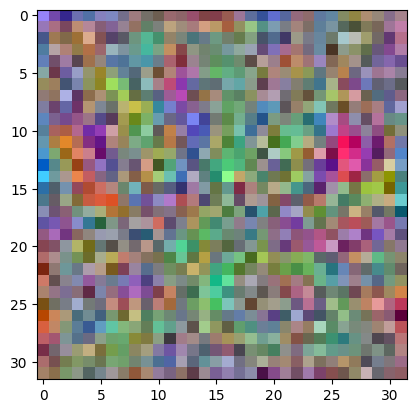

In [7]:
a=model.linear.weight[0] #inspect class 0 weight vector you have to repeat this for every class
b=a.reshape([3,32,32]);
c=b.cpu().detach().numpy()

c[1]=(c[1]-c[1].min())/(c[1].max()-c[1].min()) # normalize the each color  channels
c[2]=(c[2]-c[2].min())/(c[2].max()-c[2].min())
c[0]=(c[0]-c[0].min())/(c[0].max()-c[0].min())

plt.imshow(np.transpose(c, (1, 2, 0)))



In [8]:
# Evaluation on test set
print("\n" + "="*60)
print("EVALUATION ON TEST SET")
print("="*60)

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    # iterate over test data
    for data, target in testloader:
        # move tensors to device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = correct_tensor.cpu().numpy()
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)

print(f'\nTest Loss: {test_loss:.6f}')
print(f'\n{"="*60}')
print("PER-CLASS ACCURACY")
print(f'{"="*60}')

accuracies = {}
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        accuracies[classes[i]] = accuracy
        print('Test Accuracy of %5s: %5.2f%% (%4d/%4d)' % (
            classes[i], accuracy,
            int(class_correct[i]), int(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print(f'\n{"="*60}')
print(f'Test Accuracy (Overall): {overall_accuracy:.2f}% ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')
print(f'{"="*60}')


EVALUATION ON TEST SET

Test Loss: 1.920910

PER-CLASS ACCURACY
Test Accuracy of plane: 43.60% ( 436/1000)
Test Accuracy of   car: 45.50% ( 455/1000)
Test Accuracy of  bird: 27.90% ( 279/1000)
Test Accuracy of   cat: 24.10% ( 241/1000)
Test Accuracy of  deer: 27.40% ( 274/1000)
Test Accuracy of   dog: 35.40% ( 354/1000)
Test Accuracy of  frog: 31.10% ( 311/1000)
Test Accuracy of horse: 45.40% ( 454/1000)
Test Accuracy of  ship: 48.10% ( 481/1000)
Test Accuracy of truck: 33.40% ( 334/1000)

Test Accuracy (Overall): 36.19% (3619/10000)


## Analysis


In [9]:
# Analysis
print(f'\n{"="*60}')
print("ANALYSIS")
print(f'{"="*60}')

# Random guessing baseline
random_guess_accuracy = 100.0 / 10  # 10 classes
print(f'\n1. Random Guessing Baseline: {random_guess_accuracy:.2f}%')
print(f'   Our Model: {overall_accuracy:.2f}%')
print(f'   Improvement over random: {overall_accuracy - random_guess_accuracy:.2f}%')
print(f'   Relative improvement: {(overall_accuracy / random_guess_accuracy):.2f}x')

# Best and worst performing classes
best_class = max(accuracies, key=accuracies.get)
worst_class = min(accuracies, key=accuracies.get)

print(f'\n2. Best Performing Class: {best_class} ({accuracies[best_class]:.2f}%)')
print(f'   Worst Performing Class: {worst_class} ({accuracies[worst_class]:.2f}%)')
print(f'   Performance gap: {accuracies[best_class] - accuracies[worst_class]:.2f}%')
print(f'{"="*60}')



ANALYSIS

1. Random Guessing Baseline: 10.00%
   Our Model: 36.19%
   Improvement over random: 26.19%
   Relative improvement: 3.62x

2. Best Performing Class: ship (48.10%)
   Worst Performing Class: cat (24.10%)
   Performance gap: 24.00%


## Visualize Results


Visualization saved to 'classifier_results.png'


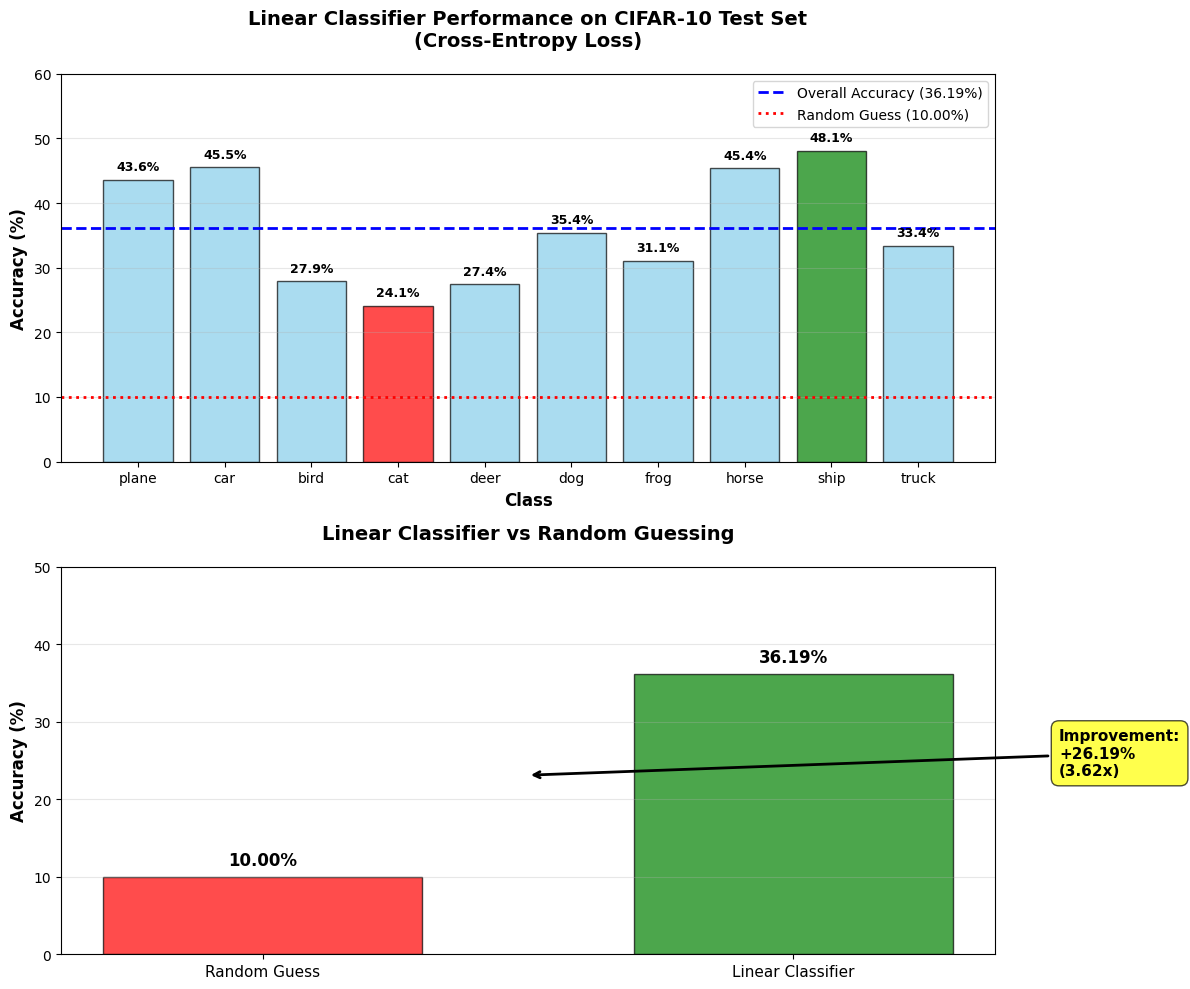

In [12]:
# Visualize results
random_guess = 10.0
accuracy_list = [accuracies[cls] for cls in classes]

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Per-class accuracy bar chart
ax1 = axes[0]
colors = ['green' if acc == max(accuracy_list) else 'red' if acc == min(accuracy_list) else 'skyblue' for acc in accuracy_list]
bars = ax1.bar(classes, accuracy_list, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=overall_accuracy, color='blue', linestyle='--', linewidth=2, label=f'Overall Accuracy ({overall_accuracy:.2f}%)')
ax1.axhline(y=random_guess, color='red', linestyle=':', linewidth=2, label=f'Random Guess ({random_guess:.2f}%)')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_title('Linear Classifier Performance on CIFAR-10 Test Set\n(Cross-Entropy Loss)',
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 60)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracy_list)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Comparison chart
ax2 = axes[1]
comparison_data = {
    'Random Guess': random_guess,
    'Linear Classifier': overall_accuracy
}
x_pos = np.arange(len(comparison_data))
bars2 = ax2.bar(x_pos, list(comparison_data.values()),
               color=['red', 'green'], alpha=0.7, edgecolor='black', width=0.6)
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Linear Classifier vs Random Guessing', fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(list(comparison_data.keys()), fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 50)

# Add value labels and improvement
for i, (bar, value) in enumerate(zip(bars2, comparison_data.values())):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add improvement annotation
improvement = overall_accuracy - random_guess
ax2.annotate(f'Improvement:\n+{improvement:.2f}%\n({overall_accuracy/random_guess:.2f}x)',
            xy=(0.5, (random_guess + overall_accuracy)/2),
            xytext=(1.5, (random_guess + overall_accuracy)/2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', lw=2, color='black'))

plt.tight_layout()
plt.savefig('classifier_results.png', dpi=300, bbox_inches='tight')
print("Visualization saved to 'classifier_results.png'")
plt.show()


## Save Model


In [11]:
# Save the model
print(f'\n{"="*60}')
torch.save(model.state_dict(), 'linear_classifier.pth')
print("Model saved to 'linear_classifier.pth'")
print(f'{"="*60}')



Model saved to 'linear_classifier.pth'


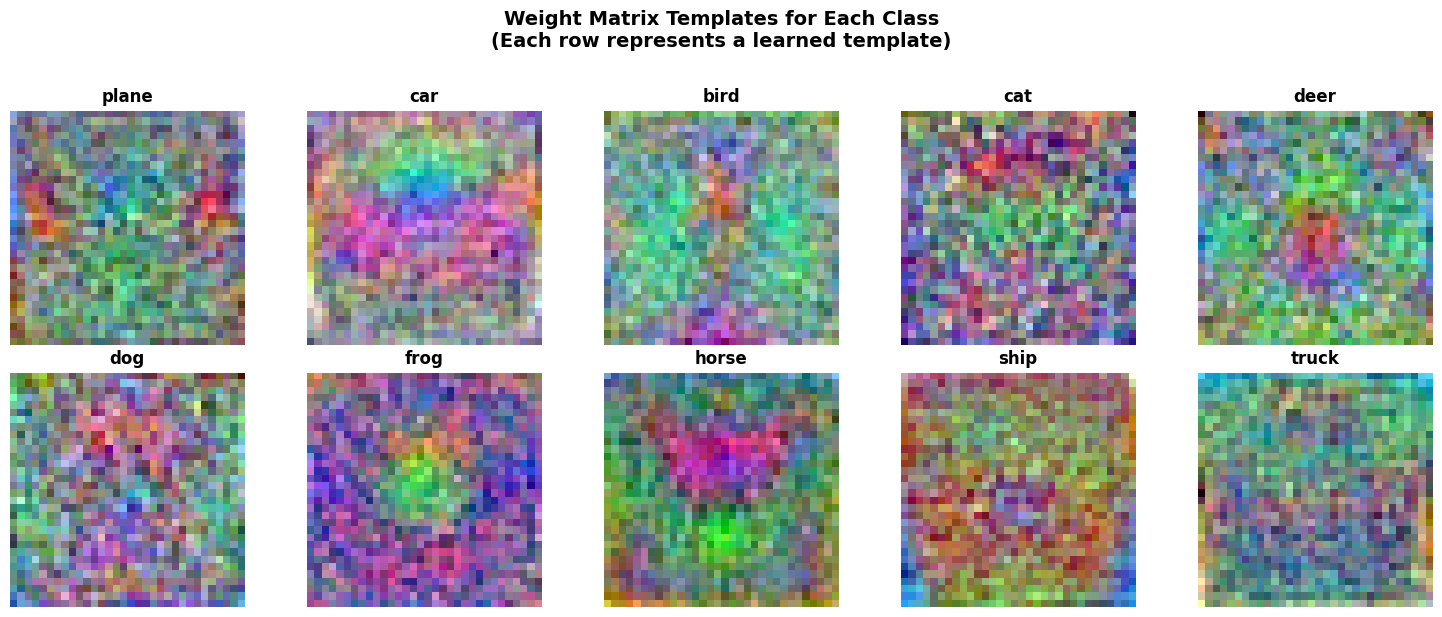


INTERPRETATION OF WEIGHT TEMPLATES

Each row of the weight matrix can be interpreted as a template for a given class.
When reshaped into a 32×32×3 color image, these templates reveal what patterns 
the linear classifier has learned to recognize for each class.

Key Observations:
1. The templates show learned discriminative patterns - regions with positive weights
   (bright areas) indicate features that increase the class score, while negative 
   weights (dark areas) indicate features that decrease it.

2. Some classes show more recognizable patterns (e.g., vehicles may show edges or 
   shapes), while others appear more abstract due to the linear classifier's 
   limitations in capturing complex spatial relationships.

3. The templates represent the optimal linear combination of pixel values that 
   best separates each class from the others, learned through the training process.

4. Since this is a linear classifier, the templates are essentially learned 
   "prototypes" that the m

In [18]:
# Extract and visualize weight templates for all 10 classes
# Each row of the weight matrix represents a template for a given class

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get the weight matrix (10 classes x 3072 features)
weight_matrix = model.linear.weight.cpu().detach().numpy()

# Create a figure with subplots for all 10 classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Process and visualize each class template
for class_idx in range(10):
    # Extract weight vector for this class
    weight_vector = weight_matrix[class_idx]
    
    # Reshape to 3x32x32 (RGB channels x height x width)
    weight_image = weight_vector.reshape(3, 32, 32)
    
    # Normalize each color channel independently to [0, 1] for visualization
    for channel in range(3):
        channel_data = weight_image[channel]
        min_val = channel_data.min()
        max_val = channel_data.max()
        if max_val > min_val:  # Avoid division by zero
            weight_image[channel] = (channel_data - min_val) / (max_val - min_val)
        else:
            weight_image[channel] = channel_data
    
    # Transpose to (32, 32, 3) for matplotlib
    weight_image_display = np.transpose(weight_image, (1, 2, 0))
    
    # Plot the template
    axes[class_idx].imshow(weight_image_display)
    axes[class_idx].set_title(f'{classes[class_idx]}', fontsize=12, fontweight='bold')
    axes[class_idx].axis('off')

plt.suptitle('Weight Matrix Templates for Each Class\n(Each row represents a learned template)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION OF WEIGHT TEMPLATES")
print("="*70)
print("""
Each row of the weight matrix can be interpreted as a template for a given class.
When reshaped into a 32×32×3 color image, these templates reveal what patterns 
the linear classifier has learned to recognize for each class.

Key Observations:
1. The templates show learned discriminative patterns - regions with positive weights
   (bright areas) indicate features that increase the class score, while negative 
   weights (dark areas) indicate features that decrease it.

2. Some classes show more recognizable patterns (e.g., vehicles may show edges or 
   shapes), while others appear more abstract due to the linear classifier's 
   limitations in capturing complex spatial relationships.

3. The templates represent the optimal linear combination of pixel values that 
   best separates each class from the others, learned through the training process.

4. Since this is a linear classifier, the templates are essentially learned 
   "prototypes" that the model uses to make decisions through a simple dot product 
   with the input image.
""")
print("="*70)

In [19]:
# Extract weight matrix W and bias vector b from the trained model
W = model.linear.weight.data.cpu().numpy()  # Shape: (10, 3072)
b = model.linear.bias.data.cpu().numpy()     # Shape: (10,)

print(f"Weight matrix W shape: {W.shape}")
print(f"Bias vector b shape: {b.shape}")
print(f"\nNumber of classes: {len(classes)}")

Weight matrix W shape: (10, 3072)
Bias vector b shape: (10,)

Number of classes: 10


In [20]:
# Collect all test images and their labels
model.eval()
all_test_images = []
all_test_labels = []
all_test_scores = []  # Will store scores for all classes for each image

with torch.no_grad():
    for data, target in testloader:
        data = data.to(device)
        # Flatten images
        flattened = torch.flatten(data, 1).cpu().numpy()  # Shape: (batch_size, 3072)
        # Compute scores for all classes: W @ x + b
        scores = flattened @ W.T + b  # Shape: (batch_size, 10)
        
        all_test_images.append(data.cpu())
        all_test_labels.append(target.numpy())
        all_test_scores.append(scores)

# Concatenate all batches
all_test_images = torch.cat(all_test_images, dim=0)  # Shape: (10000, 3, 32, 32)
all_test_labels = np.concatenate(all_test_labels, axis=0)  # Shape: (10000,)
all_test_scores = np.concatenate(all_test_scores, axis=0)  # Shape: (10000, 10)

print(f"Total test images: {len(all_test_images)}")
print(f"Test scores shape: {all_test_scores.shape}")

Total test images: 10000
Test scores shape: (10000, 10)


In [21]:
# For each class, find the images with highest and lowest scores
# These represent images farthest from the hyperplane on each side

def denormalize_image(tensor):
    """Convert normalized tensor back to [0, 1] range for display"""
    # Reverse normalization: (x + 1) / 2
    return (tensor + 1) / 2

# Find extreme images for each class
extreme_images = {}
for class_idx in range(10):
    class_scores = all_test_scores[:, class_idx]  # Scores for this class across all images
    
    # Find index of highest score (farthest on positive side)
    max_idx = np.argmax(class_scores)
    max_score = class_scores[max_idx]
    
    # Find index of lowest score (farthest on negative side)
    min_idx = np.argmin(class_scores)
    min_score = class_scores[min_idx]
    
    extreme_images[class_idx] = {
        'max_image': all_test_images[max_idx],
        'max_score': max_score,
        'max_label': all_test_labels[max_idx],
        'max_idx': max_idx,
        'min_image': all_test_images[min_idx],
        'min_score': min_score,
        'min_label': all_test_labels[min_idx],
        'min_idx': min_idx
    }
    
    print(f"{classes[class_idx]:>6s}: Max score = {max_score:7.2f} (true label: {classes[all_test_labels[max_idx]]}), "
          f"Min score = {min_score:7.2f} (true label: {classes[all_test_labels[min_idx]]})")

 plane: Max score =    6.47 (true label: ship), Min score =   -4.97 (true label: bird)
   car: Max score =    9.11 (true label: car), Min score =   -8.14 (true label: bird)
  bird: Max score =    6.18 (true label: deer), Min score =   -5.54 (true label: car)
   cat: Max score =    6.11 (true label: cat), Min score =   -5.71 (true label: car)
  deer: Max score =    7.26 (true label: deer), Min score =   -5.38 (true label: truck)
   dog: Max score =    5.73 (true label: dog), Min score =   -4.61 (true label: car)
  frog: Max score =    8.78 (true label: frog), Min score =   -6.07 (true label: car)
 horse: Max score =    7.59 (true label: horse), Min score =   -7.26 (true label: cat)
  ship: Max score =    9.47 (true label: plane), Min score =   -7.24 (true label: frog)
 truck: Max score =    9.29 (true label: car), Min score =   -7.50 (true label: horse)


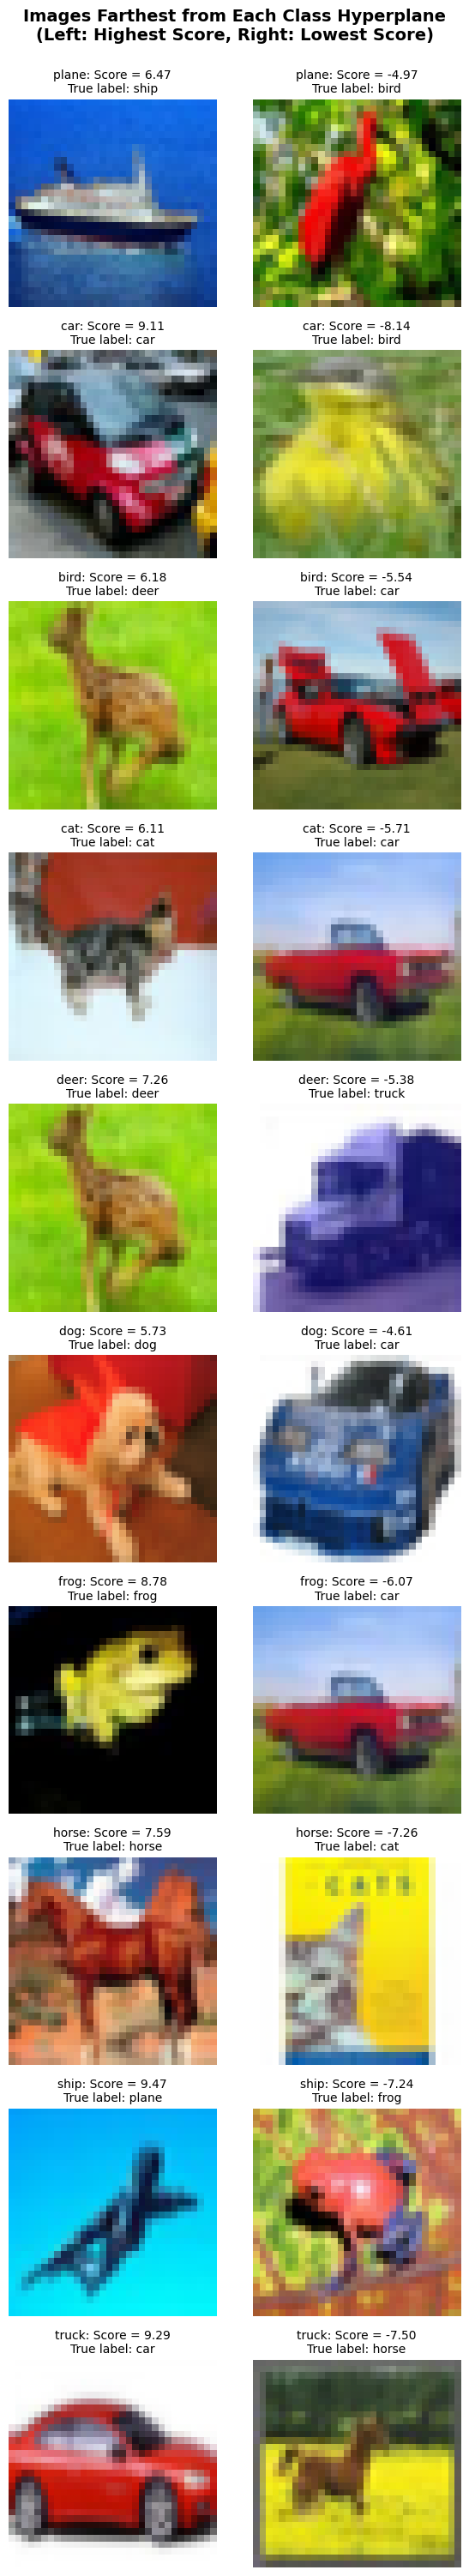

In [29]:
# Plot the extreme images for each class
fig, axes = plt.subplots(10, 2, figsize=(6, 30))
fig.suptitle('Images Farthest from Each Class Hyperplane\n(Left: Highest Score, Right: Lowest Score)', 
             fontsize=14, fontweight='bold',y=1)

for class_idx in range(10):
    # Highest score image (positive side)
    img_max = extreme_images[class_idx]['max_image']
    img_max_denorm = denormalize_image(img_max)
    axes[class_idx, 0].imshow(img_max_denorm.permute(1, 2, 0).numpy())
    axes[class_idx, 0].set_title(f'{classes[class_idx]}: Score = {extreme_images[class_idx]["max_score"]:.2f}\n'
                                 f'True label: {classes[extreme_images[class_idx]["max_label"]]}', 
                                 fontsize=10)
    axes[class_idx, 0].axis('off')
    
    # Lowest score image (negative side)
    img_min = extreme_images[class_idx]['min_image']
    img_min_denorm = denormalize_image(img_min)
    axes[class_idx, 1].imshow(img_min_denorm.permute(1, 2, 0).numpy())
    axes[class_idx, 1].set_title(f'{classes[class_idx]}: Score = {extreme_images[class_idx]["min_score"]:.2f}\n'
                                 f'True label: {classes[extreme_images[class_idx]["min_label"]]}', 
                                 fontsize=10)
    axes[class_idx, 1].axis('off')

plt.tight_layout()
plt.show()

## Is Color Information Helpful? Grayscale Classifier Comparison

In this section, we will convert the training and test data to grayscale and train a new linear classifier to compare its performance with the color classifier.

In [40]:
# Store the color classifier's accuracy for comparison
color_classifier_accuracy = overall_accuracy
color_classifier_test_loss = test_loss
color_classifier_accuracies = accuracies.copy()

print(f"Color Classifier - Overall Accuracy: {color_classifier_accuracy:.2f}%")
print(f"Color Classifier - Test Loss: {color_classifier_test_loss:.6f}")

Color Classifier - Overall Accuracy: 36.19%
Color Classifier - Test Loss: 1.920910


In [41]:
# Convert CIFAR-10 data to grayscale
# Create a transform that converts RGB to grayscale
transform_grayscale = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),  # Convert to single channel
    transforms.Normalize((0.5,), (0.5,))  # Normalize for single channel
])

# Load training and test data with grayscale transform
print("Loading CIFAR-10 dataset in grayscale...")
trainset_gray = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False, transform=transform_grayscale)
trainloader_gray = torch.utils.data.DataLoader(trainset_gray, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

testset_gray = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=False, transform=transform_grayscale)
testloader_gray = torch.utils.data.DataLoader(testset_gray, batch_size=batch_size,
                                             shuffle=False, num_workers=0)

print("Grayscale data loaded successfully!")
print(f"Grayscale image shape: {trainset_gray[0][0].shape}")  # Should be [1, 32, 32] instead of [3, 32, 32]

Loading CIFAR-10 dataset in grayscale...
Grayscale data loaded successfully!
Grayscale image shape: torch.Size([1, 32, 32])


In [42]:
# Define the Linear Classifier for Grayscale (input_dim = 32*32*1 = 1024)
class LinearClassifierGrayscale(torch.nn.Module):
    def __init__(self, input_dim=32*32*1, output_dim=10):
        super(LinearClassifierGrayscale, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

# Initialize grayscale model, loss function, and optimizer
model_gray = LinearClassifierGrayscale()
model_gray = model_gray.to(device)

criterion_gray = torch.nn.CrossEntropyLoss()
optimizer_gray = torch.optim.SGD(model_gray.parameters(), lr=0.001, momentum=0.9)

print("Grayscale model initialized!")
print(f"Model input dimension: {32*32*1} (grayscale)")
print(f"Model output dimension: 10 (classes)")

Grayscale model initialized!
Model input dimension: 1024 (grayscale)
Model output dimension: 10 (classes)


In [43]:
# Training the grayscale classifier
print(f"\nTraining grayscale classifier for {n_epochs} epochs...")
print("="*60)

for epoch in range(1, n_epochs + 1):
    train_loss_gray = 0.0

    model_gray.train()
    for data, target in trainloader_gray:
        # Move tensors to device
        data, target = data.to(device), target.to(device)

        # Clear gradients
        optimizer_gray.zero_grad()

        # Forward pass
        output = model_gray(data)

        # Calculate loss
        loss = criterion_gray(output, target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer_gray.step()

        # Update training loss
        train_loss_gray += loss.item() * data.size(0)

    # Calculate average loss
    train_loss_gray = train_loss_gray / len(trainloader_gray.dataset)

    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}/{n_epochs} \tTraining Loss: {train_loss_gray:.6f}')

print("\nGrayscale classifier training completed!")
print("="*60)


Training grayscale classifier for 25 epochs...
Epoch: 5/25 	Training Loss: 2.015145
Epoch: 10/25 	Training Loss: 2.002412
Epoch: 15/25 	Training Loss: 1.993427
Epoch: 20/25 	Training Loss: 1.988503
Epoch: 25/25 	Training Loss: 1.985965

Grayscale classifier training completed!


In [ ]:
# Evaluation on test set for grayscale classifier
print("\n" + "="*60)
print("EVALUATION ON TEST SET (GRAYSCALE CLASSIFIER)")
print("="*60)

test_loss_gray = 0.0
class_correct_gray = list(0. for i in range(10))
class_total_gray = list(0. for i in range(10))

model_gray.eval()
with torch.no_grad():
    for data, target in testloader_gray:
        # Move tensors to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model_gray(data)

        # Calculate loss
        loss = criterion_gray(output, target)
        test_loss_gray += loss.item() * data.size(0)

        # Get predictions
        _, pred = torch.max(output, 1)

        # Compare predictions to true labels
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = correct_tensor.cpu().numpy()

        # Calculate test accuracy for each class
        for i in range(len(target)):
            label = target.data[i]
            class_correct_gray[label] += correct[i].item()
            class_total_gray[label] += 1

# Calculate average test loss
test_loss_gray = test_loss_gray / len(testloader_gray.dataset)

print(f'\nTest Loss: {test_loss_gray:.6f}')
print(f'\n{"="*60}')
print("PER-CLASS ACCURACY (GRAYSCALE)")
print(f'{"="*60}')

accuracies_gray = {}
for i in range(10):
    if class_total_gray[i] > 0:
        accuracy = 100 * class_correct_gray[i] / class_total_gray[i]
        accuracies_gray[classes[i]] = accuracy
        print('Test Accuracy of %5s: %5.2f%% (%4d/%4d)' % (
            classes[i], accuracy,
            int(class_correct_gray[i]), int(class_total_gray[i])))

overall_accuracy_gray = 100. * np.sum(class_correct_gray) / np.sum(class_total_gray)
print(f'\n{"="*60}')
print(f'Test Accuracy (Overall): {overall_accuracy_gray:.2f}% ({int(np.sum(class_correct_gray))}/{int(np.sum(class_total_gray))})')
print(f'{"="*60}')

In [44]:
# Compare Color vs Grayscale Classifier Performance
print("\n" + "="*60)
print("COMPARISON: COLOR vs GRAYSCALE CLASSIFIER")
print("="*60)

print(f"\n{'Metric':<30} {'Color':<15} {'Grayscale':<15} {'Difference':<15}")
print("-" * 75)
print(f"{'Overall Accuracy (%)':<30} {color_classifier_accuracy:<15.2f} {overall_accuracy_gray:<15.2f} {overall_accuracy_gray - color_classifier_accuracy:<15.2f}")
print(f"{'Test Loss':<30} {color_classifier_test_loss:<15.6f} {test_loss_gray:<15.6f} {test_loss_gray - color_classifier_test_loss:<15.6f}")

print(f"\n{'='*60}")
print("PER-CLASS COMPARISON")
print(f"{'='*60}")
print(f"{'Class':<15} {'Color Acc (%)':<15} {'Gray Acc (%)':<15} {'Difference':<15}")
print("-" * 60)

for class_name in classes:
    color_acc = color_classifier_accuracies[class_name]
    gray_acc = accuracies_gray[class_name]
    diff = gray_acc - color_acc
    print(f"{class_name:<15} {color_acc:<15.2f} {gray_acc:<15.2f} {diff:<15.2f}")

# Calculate performance drop
performance_drop = color_classifier_accuracy - overall_accuracy_gray
performance_drop_percent = (performance_drop / color_classifier_accuracy) * 100

print(f"\n{'='*60}")
print(f"Performance Summary:")
print(f"  Color classifier accuracy: {color_classifier_accuracy:.2f}%")
print(f"  Grayscale classifier accuracy: {overall_accuracy_gray:.2f}%")
print(f"  Absolute drop: {performance_drop:.2f} percentage points")
print(f"  Relative drop: {performance_drop_percent:.2f}%")
print(f"{'='*60}")


COMPARISON: COLOR vs GRAYSCALE CLASSIFIER

Metric                         Color           Grayscale       Difference     
---------------------------------------------------------------------------
Overall Accuracy (%)           36.19           26.51           -9.68          
Test Loss                      1.920910        2.085429        0.164519       

PER-CLASS COMPARISON
Class           Color Acc (%)   Gray Acc (%)    Difference     
------------------------------------------------------------
plane           43.60           37.50           -6.10          
car             45.50           33.70           -11.80         
bird            27.90           14.40           -13.50         
cat             24.10           20.20           -3.90          
deer            27.40           32.40           5.00           
dog             35.40           18.70           -16.70         
frog            31.10           12.10           -19.00         
horse           45.40           23.00           

## Rotation Invariance Test

In this section, we test whether our linear classifier is rotation invariant by rotating the test images 90 degrees and comparing the performance.

In [36]:
# Store original test accuracy for comparison
original_test_accuracy = overall_accuracy
print(f"Original test accuracy: {original_test_accuracy:.2f}%")
print(f"\n{'='*60}")
print("TESTING ROTATION INVARIANCE")
print(f"{'='*60}")
print("\nRotating test images 90 degrees clockwise...")

Original test accuracy: 36.19%

TESTING ROTATION INVARIANCE

Rotating test images 90 degrees clockwise...


In [37]:
# Evaluate on rotated test images (90 degrees clockwise)
# Rotate images using torch.rot90 (k=1 means 90 degrees, k=3 would be 270 degrees)
# For 90-degree clockwise rotation, we use k=1 and dims=(2,3) to rotate in the spatial dimensions

test_loss_rotated = 0.0
class_correct_rotated = list(0. for i in range(10))
class_total_rotated = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    # iterate over test data
    for data, target in testloader:
        # move tensors to device
        data, target = data.to(device), target.to(device)
        
        # Rotate images 90 degrees clockwise
        # torch.rot90 rotates counter-clockwise by default, so k=3 gives 90 degrees clockwise
        # Alternatively, k=1 with dims=(2,3) rotates 90 degrees counter-clockwise
        # For 90 degrees clockwise, we use k=3
        data_rotated = torch.rot90(data, k=3, dims=(2, 3))
        
        # forward pass: compute predicted outputs by passing rotated inputs to the model
        output = model(data_rotated)
        # calculate the batch loss
        loss = criterion(output, target)
        test_loss_rotated += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = correct_tensor.cpu().numpy()
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct_rotated[label] += correct[i].item()
            class_total_rotated[label] += 1

# average test loss
test_loss_rotated = test_loss_rotated/len(testloader.dataset)

print(f'\nRotated Test Loss: {test_loss_rotated:.6f}')
print(f'\n{"="*60}')
print("PER-CLASS ACCURACY (ROTATED 90 DEGREES)")
print(f'{"="*60}')

accuracies_rotated = {}
for i in range(10):
    if class_total_rotated[i] > 0:
        accuracy = 100 * class_correct_rotated[i] / class_total_rotated[i]
        accuracies_rotated[classes[i]] = accuracy
        print('Test Accuracy of %5s: %5.2f%% (%4d/%4d)' % (
            classes[i], accuracy,
            int(class_correct_rotated[i]), int(class_total_rotated[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

overall_accuracy_rotated = 100. * np.sum(class_correct_rotated) / np.sum(class_total_rotated)
print(f'\n{"="*60}')
print(f'Test Accuracy (Overall, Rotated): {overall_accuracy_rotated:.2f}% ({int(np.sum(class_correct_rotated))}/{int(np.sum(class_total_rotated))})')
print(f'{"="*60}')


Rotated Test Loss: 2.421027

PER-CLASS ACCURACY (ROTATED 90 DEGREES)
Test Accuracy of plane: 19.00% ( 190/1000)
Test Accuracy of   car: 22.40% ( 224/1000)
Test Accuracy of  bird: 18.80% ( 188/1000)
Test Accuracy of   cat: 18.80% ( 188/1000)
Test Accuracy of  deer: 22.70% ( 227/1000)
Test Accuracy of   dog: 27.50% ( 275/1000)
Test Accuracy of  frog: 48.10% ( 481/1000)
Test Accuracy of horse:  7.20% (  72/1000)
Test Accuracy of  ship: 26.80% ( 268/1000)
Test Accuracy of truck:  5.10% (  51/1000)

Test Accuracy (Overall, Rotated): 21.64% (2164/10000)


In [38]:
# Compare original vs rotated performance
print(f"\n{'='*60}")
print("COMPARISON: ORIGINAL vs ROTATED (90 DEGREES)")
print(f"{'='*60}\n")

print(f"{'Metric':<30} {'Original':<15} {'Rotated':<15} {'Difference':<15}")
print(f"{'-'*75}")
print(f"{'Overall Accuracy (%)':<30} {original_test_accuracy:<15.2f} {overall_accuracy_rotated:<15.2f} {overall_accuracy_rotated - original_test_accuracy:<15.2f}")
print(f"{'Test Loss':<30} {test_loss:<15.6f} {test_loss_rotated:<15.6f} {test_loss_rotated - test_loss:<15.6f}")

print(f"\n{'='*60}")
print("PER-CLASS ACCURACY COMPARISON")
print(f"{'='*60}\n")
print(f"{'Class':<15} {'Original':<15} {'Rotated':<15} {'Difference':<15}")
print(f"{'-'*60}")
for class_name in classes:
    orig_acc = accuracies[class_name]
    rot_acc = accuracies_rotated[class_name]
    diff = rot_acc - orig_acc
    print(f"{class_name:<15} {orig_acc:<15.2f} {rot_acc:<15.2f} {diff:<15.2f}")

# Calculate performance drop
performance_drop = original_test_accuracy - overall_accuracy_rotated
performance_drop_percent = (performance_drop / original_test_accuracy) * 100

print(f"\n{'='*60}")
print(f"Performance drop: {performance_drop:.2f}% ({performance_drop_percent:.2f}% relative decrease)")
print(f"{'='*60}")


COMPARISON: ORIGINAL vs ROTATED (90 DEGREES)

Metric                         Original        Rotated         Difference     
---------------------------------------------------------------------------
Overall Accuracy (%)           36.19           21.64           -14.55         
Test Loss                      1.920910        2.421027        0.500117       

PER-CLASS ACCURACY COMPARISON

Class           Original        Rotated         Difference     
------------------------------------------------------------
plane           43.60           19.00           -24.60         
car             45.50           22.40           -23.10         
bird            27.90           18.80           -9.10          
cat             24.10           18.80           -5.30          
deer            27.40           22.70           -4.70          
dog             35.40           27.50           -7.90          
frog            31.10           48.10           17.00          
horse           45.40           7.2


Visualizing sample rotated images:


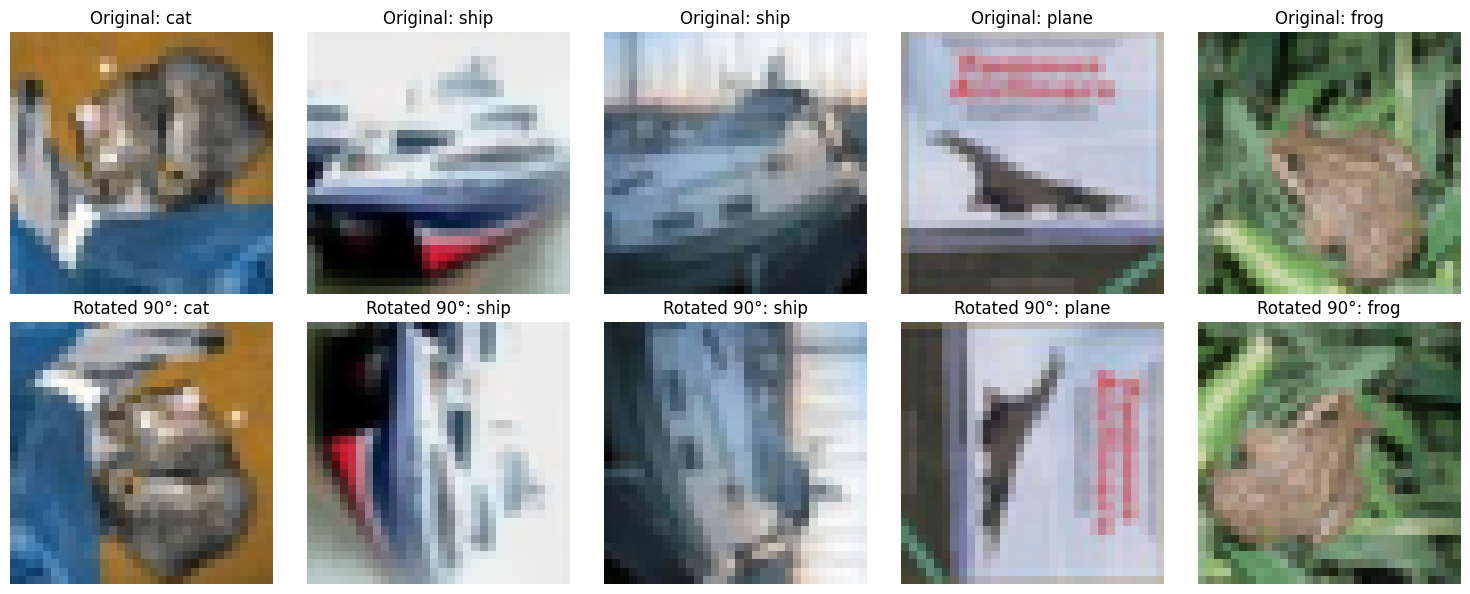

In [39]:
# Visualize a few rotated images to verify the rotation
print("\nVisualizing sample rotated images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images[:5]  # Take first 5 images
labels = labels[:5]

# Show original images
for i in range(5):
    img = images[i] / 2 + 0.5  # unnormalize
    img = img.clamp(0, 1)
    axes[0, i].imshow(img.permute(1, 2, 0).numpy())
    axes[0, i].set_title(f'Original: {classes[labels[i]]}')
    axes[0, i].axis('off')

# Show rotated images
images_rotated = torch.rot90(images, k=3, dims=(2, 3))
for i in range(5):
    img = images_rotated[i] / 2 + 0.5  # unnormalize
    img = img.clamp(0, 1)
    axes[1, i].imshow(img.permute(1, 2, 0).numpy())
    axes[1, i].set_title(f'Rotated 90°: {classes[labels[i]]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()